In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import datetime
import random
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
import xgboost
from xgboost import XGBRegressor


In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [3]:
df = pd.read_csv('Outer.csv')
apg = pd.read_csv('APG.csv')


In [4]:
target = pd.read_csv('target.csv', sep=';')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52269 entries, 0 to 52268
Data columns (total 19 columns):
Date                  52269 non-null object
Шум                   51327 non-null float64
Обратная ЭДС          51327 non-null float64
Ср.прир.напр.         49631 non-null float64
Сум.доз АПГ           51328 non-null float64
Board Temp. 1         50850 non-null float64
Board Temp. 2         50850 non-null float64
Board Temp. 3         50850 non-null float64
Board Temp. 4         50850 non-null float64
Board Temp. 5         50850 non-null float64
Board Temp. 6         50850 non-null float64
Board Temp. 7         50850 non-null float64
Board Temp. 8         50850 non-null float64
Board Temp. 9         50850 non-null float64
Board Temp. 10        50850 non-null float64
Board Face Temp. 1    50850 non-null float64
Board Face Temp. 6    50850 non-null float64
Board Deaf Temp. 1    50850 non-null float64
Board Deaf Temp. 6    50850 non-null float64
dtypes: float64(18), object(1)
memory

In [6]:
list(df)

['Date',
 'Шум',
 'Обратная ЭДС',
 'Ср.прир.напр.',
 'Сум.доз АПГ',
 'Board Temp. 1',
 'Board Temp. 2',
 'Board Temp. 3',
 'Board Temp. 4',
 'Board Temp. 5',
 'Board Temp. 6',
 'Board Temp. 7',
 'Board Temp. 8',
 'Board Temp. 9',
 'Board Temp. 10',
 'Board Face Temp. 1',
 'Board Face Temp. 6',
 'Board Deaf Temp. 1',
 'Board Deaf Temp. 6']

In [7]:
df = df.dropna()
df[list(set(list(df)) - set(['Date']))] = df[list(set(list(df)) - set(['Date']))].astype('float64')
df['Date']=pd.to_datetime(df['Date'])
df=df.sort_values(by='Date', ascending=True).reset_index(drop=True)
df['date'] = df['Date'].dt.date
df['hour'] = df['Date'].dt.hour
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48210 entries, 0 to 48209
Data columns (total 21 columns):
Date                  48210 non-null datetime64[ns]
Шум                   48210 non-null float64
Обратная ЭДС          48210 non-null float64
Ср.прир.напр.         48210 non-null float64
Сум.доз АПГ           48210 non-null float64
Board Temp. 1         48210 non-null float64
Board Temp. 2         48210 non-null float64
Board Temp. 3         48210 non-null float64
Board Temp. 4         48210 non-null float64
Board Temp. 5         48210 non-null float64
Board Temp. 6         48210 non-null float64
Board Temp. 7         48210 non-null float64
Board Temp. 8         48210 non-null float64
Board Temp. 9         48210 non-null float64
Board Temp. 10        48210 non-null float64
Board Face Temp. 1    48210 non-null float64
Board Face Temp. 6    48210 non-null float64
Board Deaf Temp. 1    48210 non-null float64
Board Deaf Temp. 6    48210 non-null float64
date                  48210 n

In [8]:
df.sort_values(by='Date')

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,...,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,date,hour
0,2018-07-30 22:46:00,0.016,2.277,-1.1,7.0,234.0,311.0,285.0,267.0,333.0,...,237.0,357.0,322.0,328.0,296.0,295.0,250.0,218.0,2018-07-30,22
1,2018-07-30 22:49:00,0.014,2.277,-0.8,7.0,236.0,313.0,284.0,270.0,333.0,...,243.0,358.0,324.0,328.0,301.0,296.0,253.0,219.0,2018-07-30,22
2,2018-07-30 22:52:00,0.016,2.277,-0.9,6.0,236.0,312.0,281.0,270.0,331.0,...,244.0,357.0,325.0,328.0,301.0,296.0,253.0,219.0,2018-07-30,22
3,2018-07-30 22:55:00,0.014,2.277,-1.0,7.0,237.0,313.0,283.0,266.0,332.0,...,243.0,359.0,325.0,328.0,300.0,296.0,252.0,218.0,2018-07-30,22
4,2018-07-30 22:58:00,0.017,2.277,-0.8,8.0,236.0,312.0,284.0,265.0,332.0,...,241.0,359.0,324.0,329.0,299.0,296.0,253.0,218.0,2018-07-30,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48205,2018-11-13 22:31:00,0.012,2.046,-2.9,7.0,232.0,228.0,288.0,229.0,365.0,...,296.0,279.0,335.0,255.0,245.0,293.0,206.0,214.0,2018-11-13,22
48206,2018-11-13 22:34:00,0.012,2.046,-2.5,8.0,230.0,225.0,288.0,230.0,366.0,...,295.0,278.0,334.0,256.0,244.0,293.0,205.0,211.0,2018-11-13,22
48207,2018-11-13 22:37:00,0.012,2.046,-2.0,6.0,233.0,227.0,290.0,229.0,366.0,...,297.0,279.0,336.0,254.0,251.0,295.0,206.0,215.0,2018-11-13,22
48208,2018-11-13 22:40:00,0.012,2.046,-2.0,6.0,233.0,227.0,289.0,231.0,366.0,...,295.0,278.0,335.0,254.0,250.0,294.0,207.0,214.0,2018-11-13,22


In [9]:
apg

,Dateparse,avg_mass_apg
0,30-Jul-18 23:00:00,0.500000
1,31-Jul-18 00:00:00,0.510000
2,31-Jul-18 01:00:00,0.510000
3,31-Jul-18 02:00:00,0.510000
4,31-Jul-18 03:00:00,0.510000
...,...,...
2023,23-Oct-18 06:00:00,0.494167
2024,23-Oct-18 07:00:00,0.494167
2025,23-Oct-18 08:00:00,0.494167
2026,23-Oct-18 09:00:00,0.494167


In [10]:
apg = apg.dropna()
apg['Dateparse']=pd.to_datetime(apg['Dateparse'])
apg.rename(columns={'Dateparse': 'Date'}, inplace=True)
apg=apg.sort_values(by='Date', ascending=True).reset_index(drop=True)
apg['date'] = apg['Date'].dt.date
apg['hour'] = apg['Date'].dt.hour
apg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 4 columns):
Date            2028 non-null datetime64[ns]
avg_mass_apg    2028 non-null float64
date            2028 non-null object
hour            2028 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 63.5+ KB


In [11]:
target = target.dropna()
target['Unnamed: 0']=pd.to_datetime(target['Unnamed: 0'])
target.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
target=target.sort_values(by='Date', ascending=True).reset_index(drop=True)
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 2 columns):
Date                131 non-null datetime64[ns]
product_percents    131 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


In [12]:
#target['date'] = target['Date'].dt.date
#target['hour'] = target['Date'].dt.hour
target

,Date,product_percents
0,2018-07-28 05:00:00,3.68
1,2018-07-28 14:00:00,3.49
2,2018-07-29 05:00:00,3.61
3,2018-07-29 14:00:00,3.65
4,2018-07-30 05:00:00,3.41
...,...,...
126,2018-09-29 05:00:00,3.39
127,2018-09-29 14:00:00,3.37
128,2018-09-30 05:00:00,3.61
129,2018-09-30 14:00:00,3.59


In [13]:
df = pd.merge(df, apg, how='inner', on=['date', 'hour'])

In [14]:
df.pop('Date_y')
df

,Date_x,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,...,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,date,hour,avg_mass_apg
0,2018-07-30 23:01:00,0.015,2.277,-0.4,5.0,237.0,313.0,284.0,267.0,331.0,...,359.0,325.0,330.0,300.0,297.0,252.0,219.0,2018-07-30,23,0.500000
1,2018-07-30 23:04:00,0.016,2.277,-0.1,7.0,237.0,313.0,284.0,267.0,331.0,...,359.0,325.0,330.0,301.0,296.0,253.0,219.0,2018-07-30,23,0.500000
2,2018-07-30 23:07:00,0.013,2.277,-0.1,7.0,236.0,313.0,284.0,267.0,331.0,...,358.0,325.0,331.0,300.0,296.0,253.0,218.0,2018-07-30,23,0.500000
3,2018-07-30 23:10:00,0.014,2.277,-0.2,7.0,236.0,313.0,283.0,269.0,330.0,...,357.0,324.0,330.0,299.0,296.0,252.0,219.0,2018-07-30,23,0.500000
4,2018-07-30 23:13:00,0.015,2.277,-0.5,7.0,237.0,314.0,282.0,269.0,330.0,...,360.0,326.0,329.0,301.0,296.0,254.0,219.0,2018-07-30,23,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38396,2018-10-23 10:46:00,0.008,1.880,-2.9,7.0,231.0,239.0,383.0,256.0,384.0,...,340.0,433.0,374.0,333.0,383.0,309.0,264.0,2018-10-23,10,0.494167
38397,2018-10-23 10:49:00,0.008,1.880,-3.1,7.0,233.0,241.0,384.0,257.0,384.0,...,338.0,432.0,373.0,331.0,385.0,309.0,264.0,2018-10-23,10,0.494167
38398,2018-10-23 10:52:00,0.000,1.902,-4.5,6.0,232.0,246.0,388.0,261.0,383.0,...,340.0,438.0,374.0,336.0,386.0,319.0,272.0,2018-10-23,10,0.494167
38399,2018-10-23 10:55:00,0.009,1.948,-3.7,6.0,235.0,239.0,387.0,258.0,384.0,...,337.0,435.0,375.0,334.0,385.0,310.0,263.0,2018-10-23,10,0.494167


In [15]:
df.rename(columns={'Date_x': 'Date'}, inplace=True)
df['mass_apg'] = df['Сум.доз АПГ'] * df['avg_mass_apg']
df

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,...,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,date,hour,avg_mass_apg,mass_apg
0,2018-07-30 23:01:00,0.015,2.277,-0.4,5.0,237.0,313.0,284.0,267.0,331.0,...,325.0,330.0,300.0,297.0,252.0,219.0,2018-07-30,23,0.500000,2.500000
1,2018-07-30 23:04:00,0.016,2.277,-0.1,7.0,237.0,313.0,284.0,267.0,331.0,...,325.0,330.0,301.0,296.0,253.0,219.0,2018-07-30,23,0.500000,3.500000
2,2018-07-30 23:07:00,0.013,2.277,-0.1,7.0,236.0,313.0,284.0,267.0,331.0,...,325.0,331.0,300.0,296.0,253.0,218.0,2018-07-30,23,0.500000,3.500000
3,2018-07-30 23:10:00,0.014,2.277,-0.2,7.0,236.0,313.0,283.0,269.0,330.0,...,324.0,330.0,299.0,296.0,252.0,219.0,2018-07-30,23,0.500000,3.500000
4,2018-07-30 23:13:00,0.015,2.277,-0.5,7.0,237.0,314.0,282.0,269.0,330.0,...,326.0,329.0,301.0,296.0,254.0,219.0,2018-07-30,23,0.500000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38396,2018-10-23 10:46:00,0.008,1.880,-2.9,7.0,231.0,239.0,383.0,256.0,384.0,...,433.0,374.0,333.0,383.0,309.0,264.0,2018-10-23,10,0.494167,3.459167
38397,2018-10-23 10:49:00,0.008,1.880,-3.1,7.0,233.0,241.0,384.0,257.0,384.0,...,432.0,373.0,331.0,385.0,309.0,264.0,2018-10-23,10,0.494167,3.459167
38398,2018-10-23 10:52:00,0.000,1.902,-4.5,6.0,232.0,246.0,388.0,261.0,383.0,...,438.0,374.0,336.0,386.0,319.0,272.0,2018-10-23,10,0.494167,2.965000
38399,2018-10-23 10:55:00,0.009,1.948,-3.7,6.0,235.0,239.0,387.0,258.0,384.0,...,435.0,375.0,334.0,385.0,310.0,263.0,2018-10-23,10,0.494167,2.965000


In [16]:
#delta = datetime.timedelta(days=days_int)
a = 1 - np.e ** (-1/300)
a = 0.002

In [17]:
model = XGBRegressor()

In [18]:
list(df)

['Date',
 'Шум',
 'Обратная ЭДС',
 'Ср.прир.напр.',
 'Сум.доз АПГ',
 'Board Temp. 1',
 'Board Temp. 2',
 'Board Temp. 3',
 'Board Temp. 4',
 'Board Temp. 5',
 'Board Temp. 6',
 'Board Temp. 7',
 'Board Temp. 8',
 'Board Temp. 9',
 'Board Temp. 10',
 'Board Face Temp. 1',
 'Board Face Temp. 6',
 'Board Deaf Temp. 1',
 'Board Deaf Temp. 6',
 'date',
 'hour',
 'avg_mass_apg',
 'mass_apg']

In [19]:
for x in list(set(list(df)) - set(['Date', 'date', 'hour'])):
    df[x] = exponential_smoothing(df[x], a)

In [20]:
df = df.groupby(['date','hour']).first().reset_index()
df = df[df['hour'].isin([5,14])]
df['Date'] = df['Date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day, x.hour, 0, 0))
df

,date,hour,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,...,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,avg_mass_apg,mass_apg
6,2018-07-31,5,2018-07-31 05:00:00,0.014174,2.285161,-0.662709,5.483806,236.953991,312.358187,283.048751,...,240.593425,358.044791,324.391954,329.393607,300.547751,294.177063,251.980100,214.251712,0.501831,2.755333
15,2018-07-31,14,2018-07-31 14:00:00,0.014160,2.271620,-1.036428,5.874404,237.894211,309.303499,284.416828,...,241.532168,356.758450,322.540368,325.532454,298.465532,291.838494,251.745760,213.142713,0.505567,2.976316
30,2018-08-01,5,2018-08-01 05:00:00,0.013429,2.221518,-1.306466,6.341397,250.998843,321.142231,295.829536,...,288.319208,364.162772,329.933615,340.074884,311.341096,306.861004,264.158831,232.160366,0.508430,3.229514
39,2018-08-01,14,2018-08-01 14:00:00,0.013554,2.176794,-1.159225,6.273639,264.717806,334.477565,304.791658,...,321.311368,368.347094,336.736693,357.893045,325.499499,319.078801,275.905730,242.204819,0.506131,3.179600
54,2018-08-02,5,2018-08-02 05:00:00,0.014209,2.166364,-1.194105,5.570420,304.106318,354.992036,324.576073,...,342.697929,370.573306,351.180686,355.728400,350.957012,325.643427,317.786787,244.513118,0.506357,2.824826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,2018-10-21,5,2018-10-21 05:00:00,0.008914,2.114448,-3.758295,6.449757,202.759558,248.841350,343.094007,...,327.361584,325.967932,369.464181,335.841885,275.898403,344.626565,265.772495,247.979297,0.495748,3.198460
1934,2018-10-21,14,2018-10-21 14:00:00,0.009201,2.120434,-3.163639,6.385057,205.062454,242.890979,352.340734,...,327.649434,322.866163,372.521550,343.727732,277.732547,340.810896,269.986282,247.822221,0.497539,3.177248
1949,2018-10-22,5,2018-10-22 05:00:00,0.009365,2.081490,-2.191305,6.173763,218.354703,243.677716,368.720322,...,334.616380,328.676527,386.751419,358.444019,296.072812,346.255521,286.487601,257.033095,0.497369,3.071407
1958,2018-10-22,14,2018-10-22 14:00:00,0.010654,2.058375,-1.641220,6.250660,216.821620,248.713229,369.602657,...,332.065133,330.662048,393.325068,361.126377,300.570553,347.204874,292.138813,259.751324,0.495501,3.097389


In [21]:
target = pd.merge(target, df, how='inner', on=['Date'])

In [22]:
target.drop(['date', 'hour', 'Сум.доз АПГ', 'avg_mass_apg'], axis=1, inplace=True)
          

In [23]:
target

,Date,product_percents,Шум,Обратная ЭДС,Ср.прир.напр.,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6,mass_apg
0,2018-07-31 05:00:00,2.95,0.014174,2.285161,-0.662709,236.953991,312.358187,283.048751,266.555282,329.949771,313.202960,240.593425,358.044791,324.391954,329.393607,300.547751,294.177063,251.980100,214.251712,2.755333
1,2018-07-31 14:00:00,3.20,0.014160,2.271620,-1.036428,237.894211,309.303499,284.416828,266.946916,333.763666,313.632620,241.532168,356.758450,322.540368,325.532454,298.465532,291.838494,251.745760,213.142713,2.976316
2,2018-08-01 05:00:00,4.32,0.013429,2.221518,-1.306466,250.998843,321.142231,295.829536,274.392642,360.206322,337.558832,288.319208,364.162772,329.933615,340.074884,311.341096,306.861004,264.158831,232.160366,3.229514
3,2018-08-01 14:00:00,5.13,0.013554,2.176794,-1.159225,264.717806,334.477565,304.791658,279.940457,378.059646,347.447393,321.311368,368.347094,336.736693,357.893045,325.499499,319.078801,275.905730,242.204819,3.179600
4,2018-08-02 05:00:00,5.04,0.014209,2.166364,-1.194105,304.106318,354.992036,324.576073,286.517982,392.840947,331.517248,342.697929,370.573306,351.180686,355.728400,350.957012,325.643427,317.786787,244.513118,2.824826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2018-09-29 05:00:00,3.39,0.008723,1.989774,-1.082546,302.998650,321.332901,268.403967,262.192225,393.543869,378.831299,339.539413,346.483302,281.208073,361.054939,291.099846,332.101685,324.214953,233.281328,3.321215
117,2018-09-29 14:00:00,3.37,0.008806,2.018065,-1.568645,296.281640,317.403731,266.263429,261.084396,392.276013,372.840364,337.161670,344.147470,278.123058,357.290659,285.940071,327.479242,318.353246,229.587591,3.297752
118,2018-09-30 05:00:00,3.61,0.009470,2.012048,-1.138894,304.451105,325.987974,271.562318,264.587620,394.656912,375.771511,343.007745,349.189934,285.429061,368.422690,303.867277,339.113836,327.468190,241.714038,3.292691
119,2018-09-30 14:00:00,3.59,0.009297,1.964635,-0.972803,306.869348,328.461581,274.022355,265.701928,394.364023,373.327068,343.129044,349.785586,286.853701,370.607632,304.240515,340.935952,328.839624,245.956671,3.317943


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    target[[col for col in target.columns if col not in ['product_percents', 'Date']]], 
    target['product_percents'], 
    test_size=0.33, 
    random_state=42)

In [25]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
y_pred

array([3.3011408, 3.3531647, 5.165858 , 3.4857447, 3.5842931, 2.9314797,
       3.4612741, 3.2538762, 3.919632 , 3.7321603, 3.6576588, 3.3288116,
       3.2989035, 4.354867 , 3.1469443, 3.4994168, 3.3199553, 3.2234254,
       3.0662565, 3.5073283, 2.9761677, 3.355902 , 3.4497125, 3.4171195,
       3.8667858, 3.475144 , 3.3516731, 3.3535721, 2.6864116, 3.75327  ,
       4.201392 , 2.7556987, 3.954765 , 3.467657 , 3.2599392, 3.379958 ,
       3.5968807, 3.6927648, 3.4086483, 2.9025578], dtype=float32)

In [27]:
check = pd.DataFrame({'pred': list(y_pred), 'test': y_test.to_list()})
check['diff'] = abs(check['pred'] - check['test'])
check['diff_relat'] = check['diff']/check['test']
print(check['diff_relat'].mean())
check['diff'].mean()

0.08286393251011152


0.2899870045185089

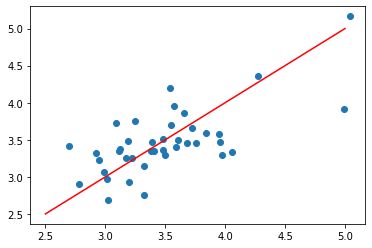

In [28]:
plt.plot(check['test'], check['pred'], 'o')
plt.plot([2.5,5], [2.5,5], 'r')

# model evaluation

In [29]:
from sklearn import metrics

In [30]:
# mean absolute error
print('mean absolute error: ', metrics.mean_absolute_error(check['pred'], check['test']))
print('relative mean absolute error: ', metrics.mean_absolute_error(check['pred']/check['test'], check['test']/check['test']) ** (1/2))

mean absolute error:  0.2899870045185089
relative mean absolute error:  0.28786096037863756


In [31]:
# mean squared error
print('mean squared error: ', metrics.mean_squared_error(check['pred'], check['test']))
print('relative mean squared error: ', metrics.mean_squared_error(check['pred']/check['test'], check['test']/check['test']) ** (1/2))

mean squared error:  0.14195819859405692
relative mean squared error:  0.10577304771684135


In [38]:
m = check['pred'].copy()
for i in range(len(m)): m[i] = check['pred'].mean()
print('mean squared error: ', metrics.mean_squared_error(check['pred'], m)**0.5)

mean squared error:  0.19056145024744492
